## Physics-Informed Neural Networks (PINNs) Practical Exercise
## Solving the 1D Heat Equation using PINNs

### imports and installations

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# set seed for reproducibility
torch.manual_seed(42)

## Configure 1D heat equation system parameters 

#### System Parameters 

In [2]:
alpha = 0.1       # original thermal diffusivity [m^2/s]
L     = 1       # domain length [m]
T_max = 1     # max time [s]
U_max = 1    # max temperature [°C]
num_domain_points = 1000
num_boundary_points = 100

system_params = {'alpha': alpha,'L': L, 'T_max': T_max, 'U_max': U_max}

### Set up initial conditions configuration
##### Consider 2 optional IC setups- sinusoidal and block heat source


In [3]:
# create a sinusoidal distribution initial condition
def i_c_sin(x_initial):
    u_initial = torch.sin(torch.pi * x_initial) 
    return u_initial

# create a block heat source initial condition (temperature distribution between 0 and 1)
def i_c_block(x_initial):
    center1 = 0.35
    center2 = 0.8
    width1 = 0.2
    width2 = 0.35
    # Create mask for points inside the block
    mask1 = (x_initial >= (center1 - width1/2)) & (x_initial <= (center1 + width1/2))
    mask2 = (x_initial >= (center2 - width2/2)) & (x_initial <= (center2 + width2/2))
    # Initialize with low temperature
    u_initial = torch.full_like(x_initial, 0)
    # Set high temperature for points inside the block
    u_initial[mask1] = 1
    u_initial[mask2] = 1
    
    return u_initial

# generate initial conditions training data
def generate_initial_data(num_boundary_points, system_params, initial_condition = i_c_sin):
    x_initial = torch.rand(num_boundary_points, 1, requires_grad=True) # random x values (0-1) for the initial condition
    t_initial = torch.zeros_like(x_initial) # time is 0 for the initial condition
    u_initial = initial_condition(x_initial) # create the initial temperature distribution
    # scale the initial data to the system parameters
    x_initial = x_initial * system_params['L']
    u_initial = u_initial * system_params['U_max']
    return x_initial, t_initial, u_initial


### Configure Boundry Conditions & Domain Training points

In [4]:
def generate_boundary_data(num_boundary_points, system_params, boundary_value=0):
    # create x_boundary and t_boundary
    x_boundary_0 = torch.zeros(num_boundary_points, 1, requires_grad=True)  # x = 0 boundary
    x_boundary_1 = torch.ones(num_boundary_points, 1, requires_grad=True) * system_params['L'] # x = L boundary
    x_boundary = torch.cat([x_boundary_0, x_boundary_1], dim=0)   # combine both boundaries

    t_boundary = torch.rand(num_boundary_points * 2, 1, requires_grad=True) * system_params['T_max']  # random time points to match the boudaries

    u_boundary = torch.full_like(x_boundary, boundary_value) # set the boundary values to the boundary points

    return x_boundary, t_boundary, u_boundary

# Generate a random setup of interior domain points to train the model on
def generate_domain_points(num_domain_points, system_params):
    x_domain = torch.rand(num_domain_points, 1, requires_grad = True) * system_params['L']
    t_domain = torch.rand(num_domain_points, 1, requires_grad = True) * system_params['T_max']
    
    return x_domain,t_domain

### Plot IC and BC

In [5]:
def plot_IC_BC(num_domain_points=num_domain_points,
                num_boundary_points=num_boundary_points,
                system_params=system_params,
                initial_condition=i_c_sin, plot_IC_alone=True):
    # Generate data
    x_domain, t_domain= generate_domain_points(num_domain_points, system_params)
    x_boundary, t_boundary, u_boundary = generate_boundary_data(num_boundary_points, system_params, boundary_value=0)
    x_initial, t_initial, u_initial = generate_initial_data(num_boundary_points, system_params, initial_condition)
    # Convert to numpy arrays
    x_init_np , t_init_np , u_init_np = x_initial.detach().numpy(), t_initial.detach().numpy(), u_initial.detach().numpy()
    x_boundary_np , t_boundary_np , u_boundary_np = x_boundary.detach().numpy(), t_boundary.detach().numpy(), u_boundary.detach().numpy()
    # Unite all x,t,u in one array
    x_np = np.concatenate((x_init_np, x_boundary_np))
    t_np = np.concatenate((t_init_np, t_boundary_np))
    u_np = np.concatenate((u_init_np, u_boundary_np))

    if plot_IC_alone:
        fig = plt.figure(figsize=(8, 4))
        # Scatter plot of u_init_np vs x_init_np
        plt.scatter(x_init_np, u_init_np, c=u_init_np, cmap='coolwarm')
        plt.xlabel('Position x (m)')
        plt.ylabel('Temperature u (°C)')
        plt.title('Initial Condition at time t=0')
        plt.colorbar(label='Temperature')
        plt.show()


    # For a 2D tilted view (alternative approach)
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Create a surface plot with zero height
    x_grid, t_grid = np.meshgrid(np.unique(x_np), np.unique(t_np))
    z_grid = np.zeros_like(x_grid)  # Create a flat surface
    ax.plot_surface(x_grid, t_grid, z_grid, alpha=0.15) # Plot the surface

    # Add scatter points
    scatter = ax.scatter(x_np, t_np, np.zeros_like(x_np), c=u_np, cmap='coolwarm')
    # Set figure view
    ax.set_xlabel('Position x (m)')
    ax.set_ylabel('Time t (s)')
    ax.set_zticks([]) # Remove z-axis
    ax.view_init(elev=20, azim=-45) # Adjust view angle for 2D-like perspective

    plt.colorbar(scatter, label='Temperature')
    plt.title('Initial Condition and Boundary Condition')
    plt.show()


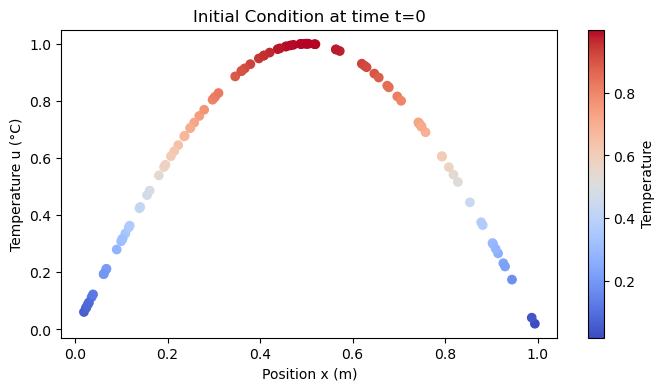

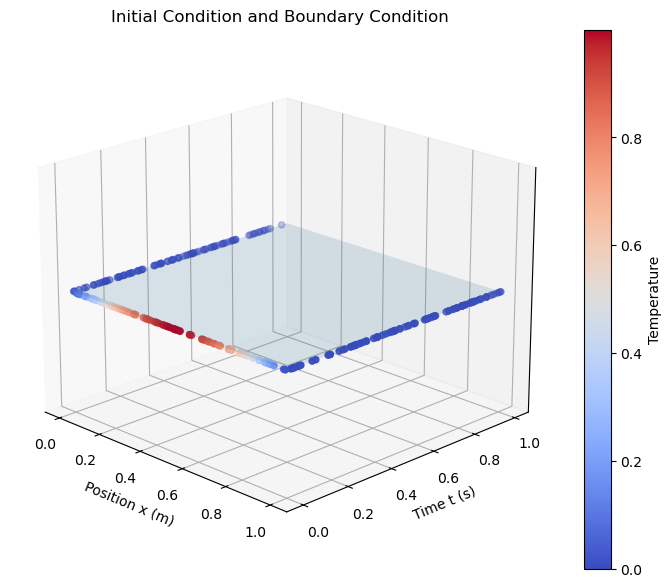

In [6]:
plot_IC_BC(num_domain_points, num_boundary_points, initial_condition=i_c_sin)

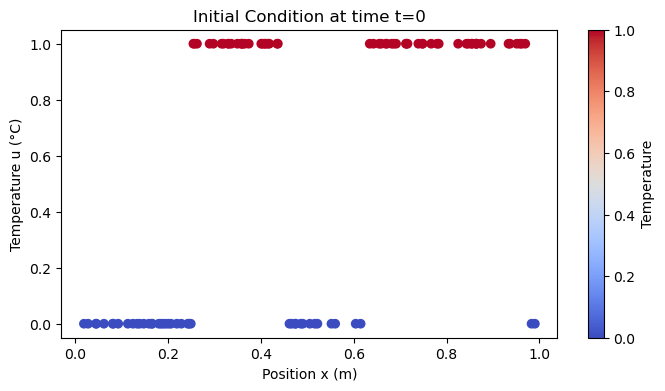

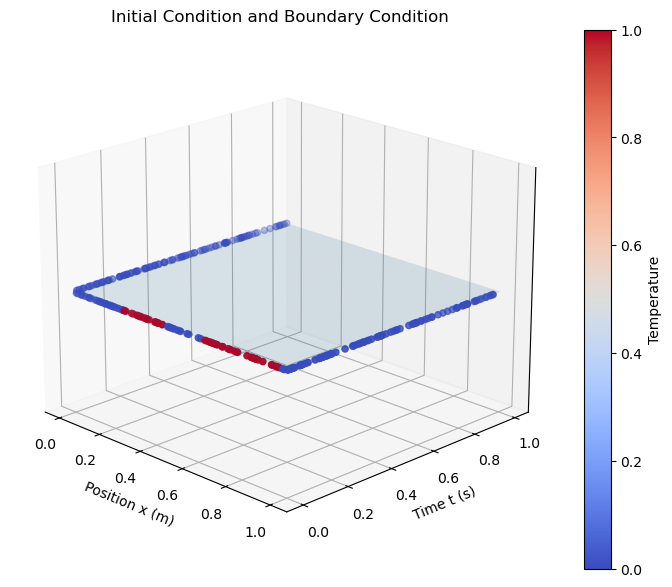

In [7]:
plot_IC_BC(num_domain_points, num_boundary_points, initial_condition=i_c_block)

## Define PINN Architecture

In [8]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN,self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,1)
        )
    def forward(self,x):
        return self.net(x)

### Define PDE residual loss
![](diff_eq.png)

In [9]:
def pde(x,t,model,system_params):
    input_data = torch.cat([x,t],dim=1)
    u = model(input_data)
    alpha= system_params['alpha']
    T_max = system_params['T_max']
    L = system_params['L']
    
    alpha_norm = alpha * T_max / L**2

    du_dx = torch.autograd.grad(u, x,grad_outputs= torch.ones_like(u), create_graph= True, retain_graph=True)[0]
    d2u_dx2 = torch.autograd.grad(du_dx,x,grad_outputs= torch.ones_like(du_dx), create_graph= True, retain_graph=True)[0]
    du_dt = torch.autograd.grad(u,t,grad_outputs= torch.ones_like(u), create_graph= True, retain_graph=True)[0]

    heat_eq_residual = du_dt - (alpha_norm * d2u_dx2)

    return heat_eq_residual

In [10]:
def train_PINN(model, num_iterations, system_params, num_domain_points, num_boundary_points, initial_condition=i_c_sin,
               loss_weights = {'ic': 1, 'bc': 1, 'pde': 1}, print_loss = True):
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    ic_losses = []
    bc_losses = []
    pde_losses = []
    total_losses = []
    w_ic = loss_weights['ic']
    w_bc = loss_weights['bc']
    w_pde = loss_weights['pde']
    
    for  iteration in range(num_iterations):
        optimizer.zero_grad()

        x_domain, t_domain= generate_domain_points(num_domain_points, system_params)
        
        x_boundary, t_boundary, u_boundary = generate_boundary_data(num_boundary_points, system_params, boundary_value=0)
        
        x_initial, t_initial, u_initial = generate_initial_data(num_boundary_points, system_params, initial_condition)
        
        residual = pde(x_domain,t_domain,model,system_params)
        
        ic_loss= nn.MSELoss()(u_initial, model(torch.cat([x_initial, t_initial], dim=1))) * w_ic
        bc_loss = nn.MSELoss()(u_boundary, model(torch.cat([x_boundary, t_boundary], dim=1))) * w_bc
        pde_loss = nn.MSELoss()(residual, torch.zeros_like(residual)) * w_pde
        loss = ic_loss + bc_loss + pde_loss
        loss.backward()
        optimizer.step()

        # Accumulate losses
        ic_losses.append(ic_loss.item())
        bc_losses.append(bc_loss.item())
        pde_losses.append(pde_loss.item())
        total_losses.append(loss.item())

    
        # Print loss every 100 iterations and check for early stopping
        if iteration % 1000 ==0:
            if print_loss:
                print("iter", iteration, "total_loss", f"{loss.item():.3f}", "ic_loss", f"{ic_loss.item():.4f}", "bc_loss", f"{bc_loss.item():.4f}", "pde_loss", f"{pde_loss.item():.4f}")

    # insert all losses to a dataframe
    df = pd.DataFrame({'ic_loss': ic_losses, 'bc_loss': bc_losses, 'pde_loss': pde_losses, 'total_loss': total_losses})
    return df


## Train model & Evaluate results

#### Ploting functions

In [11]:
def plot_PINN_results(model, system_params, num_time_steps=10, sample_results = 0):
    x_plot = []
    t_plot = []
    u_pred = []
    with torch.no_grad():
        x_vals = torch.linspace(0,system_params['L'],100)
        for t in range(num_time_steps):
            t_val = torch.ones_like(x_vals) * t/num_time_steps * system_params['T_max']
            input_data = torch.stack([x_vals.flatten(),t_val.flatten()], dim=1)
            solution = model(input_data)
            x_plot.append(x_vals)
            t_plot.append(t_val)
            u_pred.append(solution)

    # Convert to numpy and flatten all arrays
    x_plot = torch.cat(x_plot).numpy()
    t_plot = torch.cat(t_plot).numpy()
    u_pred_np = torch.cat(u_pred).numpy()

    # Plot
    plt.figure(figsize=(8, 7))
    plt.scatter(x_plot, t_plot, c=u_pred_np, cmap='coolwarm')
    plt.clim(0, system_params['U_max'])
    plt.ylim(0, system_params['T_max'])
    plt.xlabel('Position x (m)')
    plt.ylabel('Time t (s)')
    plt.title('PINN Temperature Prediction')
    plt.colorbar(label='Temperature')
    plt.show()

    # create a sample index to select random x,t,u point from the results as the number of sample_results
    if sample_results > 0:
        sample_index = np.random.randint(0, len(x_plot), sample_results)
        x_plot_sample = x_plot[sample_index]
        t_plot_sample = t_plot[sample_index]
        u_pred_sample = u_pred_np[sample_index].flatten()

        # pack to data frame
        sample_results = pd.DataFrame({'x': x_plot_sample, 't': t_plot_sample, 'u': u_pred_sample})

        return sample_results

def plot_losses(df, log_scale=False):
    plt.figure(figsize=(9, 4))
    plt.plot(df['total_loss'], label='Total Loss')
    plt.plot(df['ic_loss'], label='IC Loss')
    plt.plot(df['bc_loss'], label='BC Loss')
    plt.plot(df['pde_loss'], label='PDE Loss')
    # set y axis to log scale
    if log_scale:
        plt.yscale('log')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Losses over iterations')
    plt.legend()
    plt.show()

def plot_results_2D_tilted(x, t, u, title='Sample measurement'):
    # For a 2D tilted view (alternative approach)
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Create a surface plot with zero height
    x_grid, t_grid = np.meshgrid(np.unique(x), np.unique(t))
    z_grid = np.zeros_like(x_grid)  # Create a flat surface
    ax.plot_surface(x_grid, t_grid, z_grid, alpha=0.15) # Plot the surface

    # Add scatter points
    scatter = ax.scatter(x, t, np.zeros_like(x), c=u, cmap='coolwarm')
    # Set figure view
    ax.set_xlabel('Position x (m)')
    ax.set_ylabel('Time t (s)')
    ax.set_zticks([]) # Remove z-axis
    ax.view_init(elev=20, azim=-45) # Adjust view angle for 2D-like perspective

    plt.colorbar(scatter, label='Temperature')
    plt.title(title)
    plt.show()
    

### Block IC , Norm (0-1) Values
- Try playing with alpha values

iter 0 total_loss 0.639 ic_loss 0.6231 bc_loss 0.0153 pde_loss 0.0002
iter 1000 total_loss 0.167 ic_loss 0.1488 bc_loss 0.0110 pde_loss 0.0073
iter 2000 total_loss 0.102 ic_loss 0.0887 bc_loss 0.0033 pde_loss 0.0098
iter 3000 total_loss 0.080 ic_loss 0.0695 bc_loss 0.0018 pde_loss 0.0089
iter 4000 total_loss 0.060 ic_loss 0.0511 bc_loss 0.0020 pde_loss 0.0071
iter 5000 total_loss 0.043 ic_loss 0.0374 bc_loss 0.0022 pde_loss 0.0038
iter 6000 total_loss 0.051 ic_loss 0.0464 bc_loss 0.0007 pde_loss 0.0041
iter 7000 total_loss 0.045 ic_loss 0.0409 bc_loss 0.0015 pde_loss 0.0028
iter 8000 total_loss 0.042 ic_loss 0.0373 bc_loss 0.0016 pde_loss 0.0031
iter 9000 total_loss 0.036 ic_loss 0.0327 bc_loss 0.0013 pde_loss 0.0017


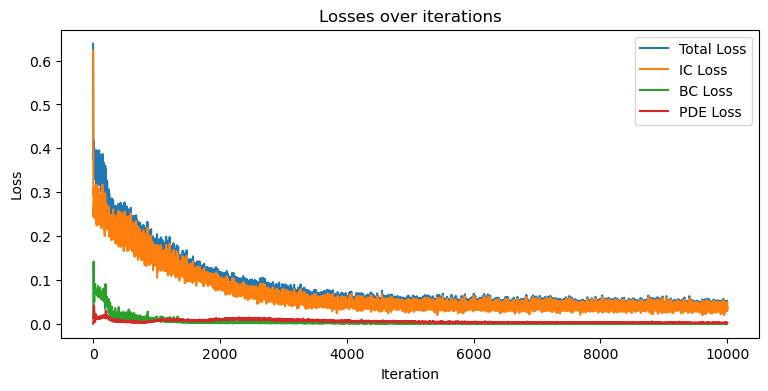

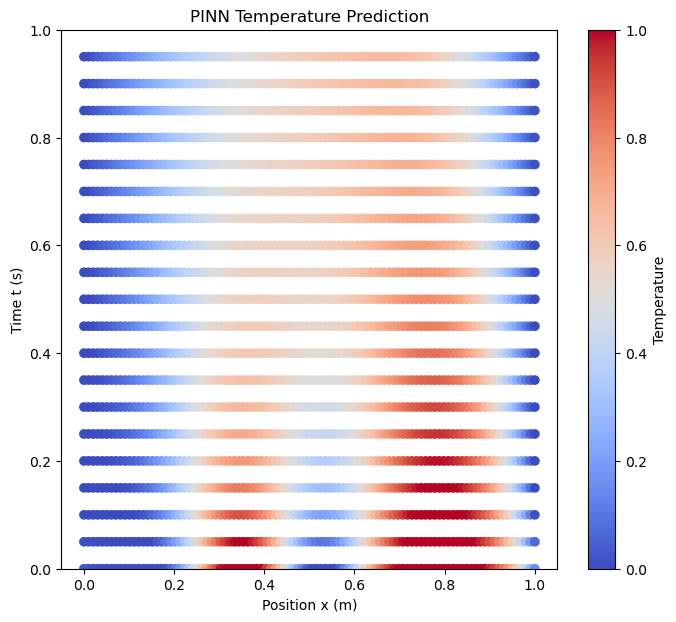

In [22]:
alpha = 0.02       # original thermal diffusivity [m^2/s]
L     = 1       # domain length [m]
T_max = 1   # max time [s]
U_max = 1   # max temperature [°C]
num_domain_points = 1000
num_boundary_points = 100

system_params = {'alpha': alpha,'L': L, 'T_max': T_max, 'U_max': U_max}

model_block_norm = PINN()
losses = train_PINN(model_block_norm,
                    num_iterations = 10000,
                    system_params = system_params,
                    num_domain_points = 1000,
                    num_boundary_points = 100,
                    initial_condition=i_c_block,
                    loss_weights= {'ic': 1, 'bc': 1, 'pde': 1},
                    )

plot_losses(losses)
plot_PINN_results(model_block_norm,system_params, num_time_steps=20)


In [ ]:
plot_losses(losses, log_scale=True)

#### No Grid Limitation
- Play with resolution

In [ ]:
sample_results_block = plot_PINN_results(model_block_norm,system_params, num_time_steps=5)



### Sinus IC , Norm (0-1) Values
- Try swithcing on/off the loss weights

iter 0 total_loss 0.943 ic_loss 0.8837 bc_loss 0.0436 pde_loss 0.0156
iter 1000 total_loss 0.000 ic_loss 0.0000 bc_loss 0.0000 pde_loss 0.0001
iter 2000 total_loss 0.000 ic_loss 0.0000 bc_loss 0.0000 pde_loss 0.0000
iter 3000 total_loss 0.000 ic_loss 0.0000 bc_loss 0.0000 pde_loss 0.0000
iter 4000 total_loss 0.000 ic_loss 0.0000 bc_loss 0.0000 pde_loss 0.0000


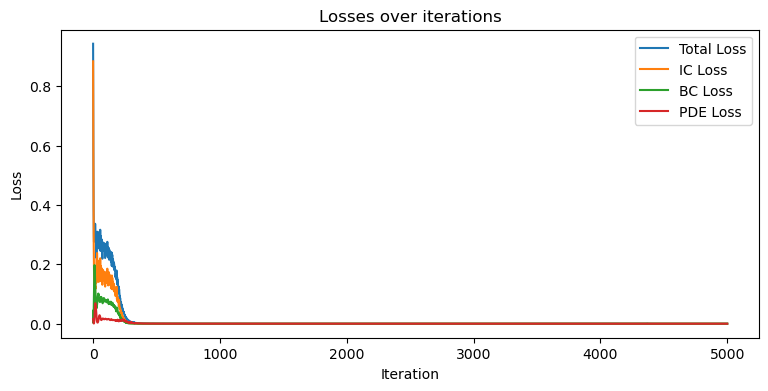

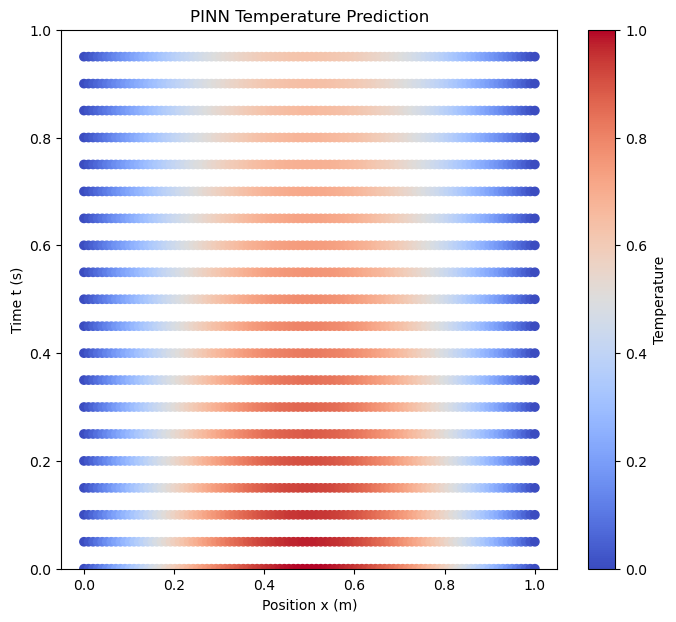

In [44]:
alpha = 0.05 # thermal diffusivity [m^2/s]
L     = 1   # domain length [m]
T_max = 1   # max time [s]
U_max = 1   # max temperature [°C]
num_domain_points = 1000
num_boundary_points = 100

system_params = {'alpha': alpha,'L': L, 'T_max': T_max, 'U_max': U_max}

model_sinus_norm = PINN()
losses = train_PINN(model_sinus_norm,
                    num_iterations = 5000,
                    system_params = system_params,
                    num_domain_points = 1000,
                    num_boundary_points = 100,
                    initial_condition=i_c_sin,
                    loss_weights= {'ic': 1, 'bc': 1, 'pde': 1},
                    )

plot_losses(losses)
plot_PINN_results(model_sinus_norm,system_params, num_time_steps=20)

### Sinus IC , "Real" Values
- Try swithcing balancing the loss weights

In [ ]:
alpha= 0.1
T_max = 1
L = 0.1

alpha_norm = alpha * T_max / L**2
alpha_norm

In [ ]:
T_max / L**2

In [ ]:
alpha = 0.1      # original thermal diffusivity [m^2/s]
L     = 10       # domain length [m]
T_max = 100   # max time [s]
U_max = 50  # max temperature [°C]
num_domain_points = 1000
num_boundary_points = 100

system_params = {'alpha': alpha,'L': L, 'T_max': T_max, 'U_max': U_max}

model = PINN()
losses = train_PINN(model,
                    num_iterations = 10000,
                    system_params = system_params,
                    num_domain_points = 1000,
                    num_boundary_points = 100,
                    initial_condition=i_c_sin,
                    loss_weights= {'ic': 0.001, 'bc': 1, 'pde': 100},
                    )

plot_losses(losses)
plot_PINN_results(model,system_params, num_time_steps=20)

## Create "measurments" data set
### Sample the model predictions point and add noise

### Block IC

#### Sample model predictions

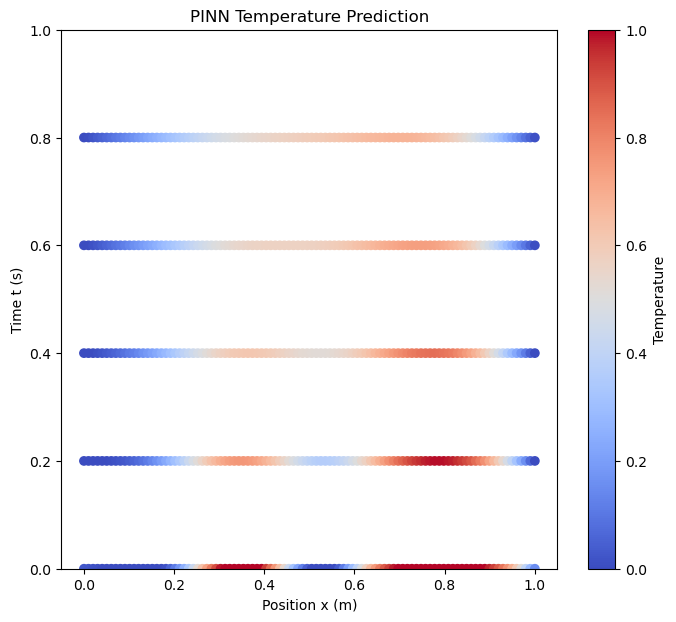

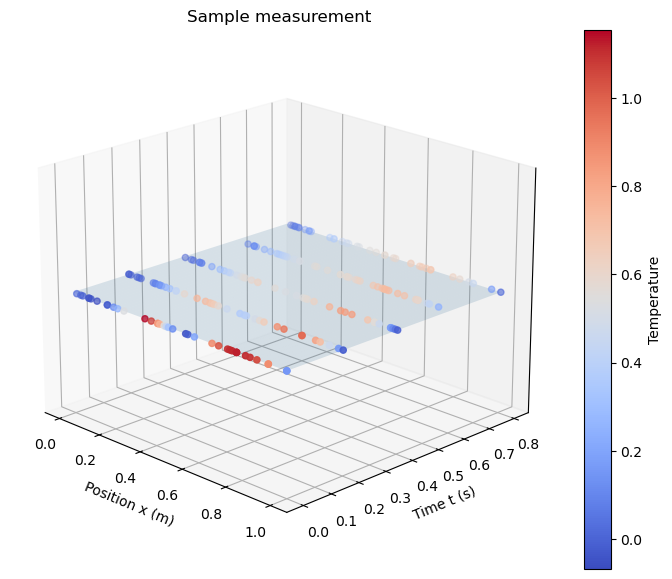

,x,t,u
0,0.040404,0.0,0.001124
138,1.000000,0.0,0.155943
29,0.818182,0.0,1.109752
30,0.171717,0.0,-0.017643
68,0.202020,0.0,0.113094
...,...,...,...
20,0.232323,0.8,0.373972
159,0.343434,0.8,0.509719
160,0.020202,0.8,0.021577
97,0.040404,0.8,0.052466


In [24]:
df_sample_results_block = plot_PINN_results(model_block_norm,system_params, num_time_steps=5, sample_results=200)
x,t,u= df_sample_results_block['x'], df_sample_results_block['t'], df_sample_results_block['u']
plot_results_2D_tilted(x,t,u)
# reorder by t
df_sample_results_block.sort_values(by='t')

#### Add random noise

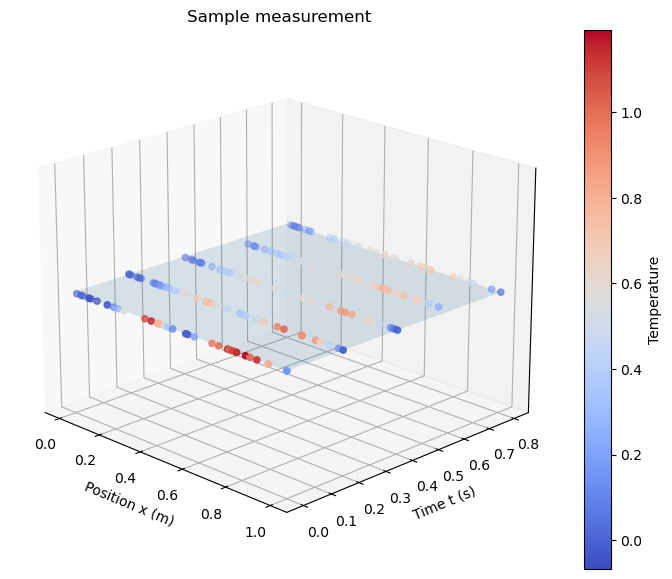

In [25]:
noise_level = 0.1
df_noisy_block = df_sample_results_block.copy()
df_noisy_block['u'] = df_noisy_block['u'] + np.random.uniform(-noise_level, noise_level, len(df_noisy_block)) * df_noisy_block['u']
x,t,u= df_noisy_block['x'], df_noisy_block['t'], df_noisy_block['u']
plot_results_2D_tilted(x,t,u)

##### Save to csv

In [26]:
### Save the df_sample_results_block to a csv file
file_name = 'sample_data_blockIC_200_alpha_0.02.csv'
df_noisy_block.to_csv('Data_sets/'+file_name, index=False)


### Sinus IC

#### Sample model predictions

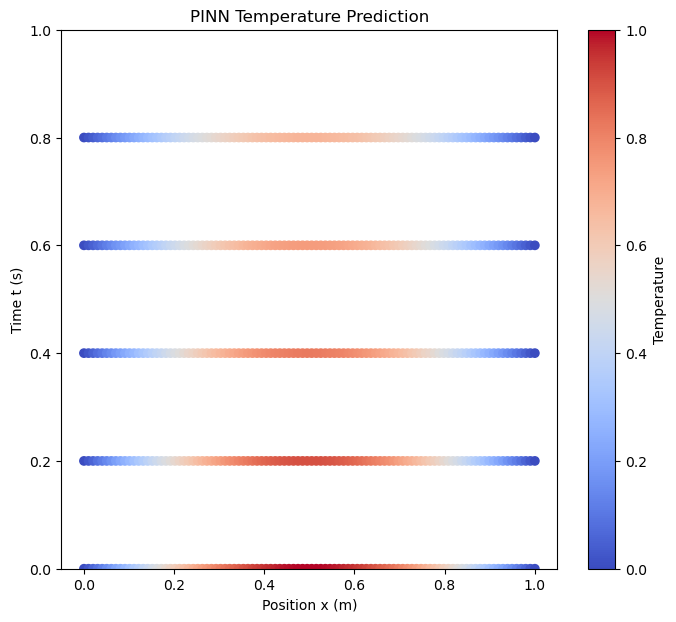

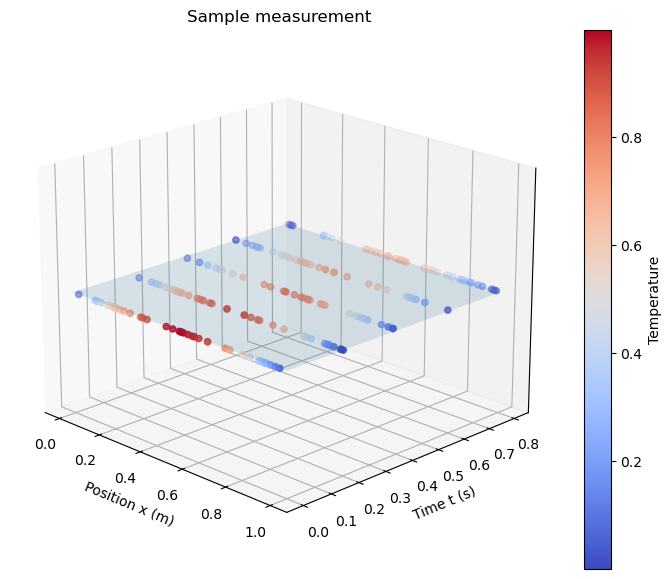

In [49]:
df_sample_results_sinus = plot_PINN_results(model_sinus_norm,system_params, 
                                            num_time_steps=5, 
                                            sample_results=200)

x, t, u = df_sample_results_sinus['x'], df_sample_results_sinus['t'], df_sample_results_sinus['u']
plot_results_2D_tilted(x,t,u)

#### Create Noise

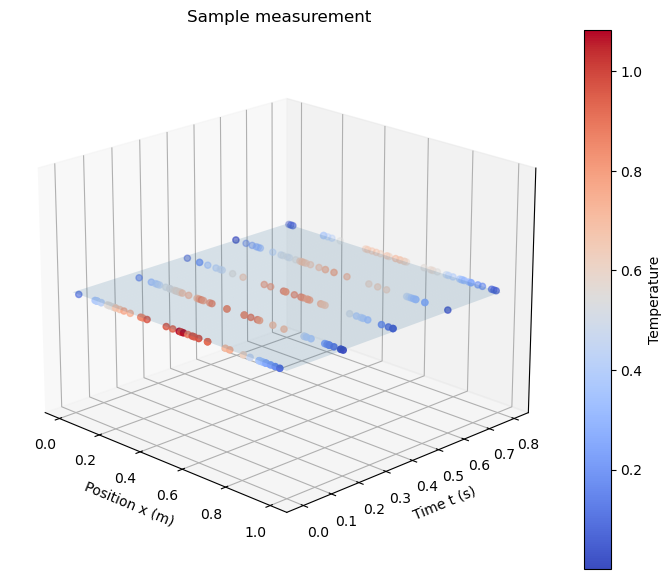

,original_u,noisy_u
0,0.712481,0.777678
1,0.676626,0.621589
2,0.114740,0.115779
3,0.232386,0.251978
4,0.655547,0.665789
...,...,...
195,0.666455,0.696925
196,0.199481,0.184939
197,0.512955,0.562911
198,0.667263,0.631139


In [50]:
noise_level = 0.1
df_noisy_sinus = df_sample_results_sinus.copy()
# create a random noise between -noise_level and noise_level
df_noisy_sinus['u'] = df_noisy_sinus['u'] + np.random.uniform(-noise_level, noise_level, len(df_noisy_sinus)) * df_noisy_sinus['u']

x,t,u= df_noisy_sinus['x'], df_noisy_sinus['t'], df_noisy_sinus['u']
plot_results_2D_tilted(x,t,u)

# create new compare_df with 2 columns, original u and noisy u
compare_df = pd.DataFrame({'original_u': df_sample_results_sinus['u'], 'noisy_u': df_noisy_sinus['u']})
compare_df

#### Save to csv

In [51]:
# save df_noisy_sinus to a csv file
file_name = 'sample_results_sinus_200_alpha_0.05.csv'
df_noisy_sinus.to_csv('Data_sets/'+file_name, index=False)